In [9]:
from torch_snippets_local import *
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import warnings
import configparser
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [10]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [11]:
# Load configuration
config = configparser.ConfigParser()
config.read('config.ini')
# Load parameters from config file
#root = '/Users/leonjye/Documents/MachineLearingData'
root = config.get('DEFAULT', 'root_dir')
IMAGE_ROOT = os.path.join(root, 'MNIST')
trn_ds = datasets.MNIST(root=IMAGE_ROOT, transform=img_transform, train=True, download=True)
val_ds = datasets.MNIST(root=IMAGE_ROOT, transform=img_transform, train=False, download=True)

In [12]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.latend_vector = None
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True), 
            #nn.Linear(64, 12),  nn.ReLU(True), 
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True), 
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        latend_vector = self.encoder(x)
        x = self.decoder(latend_vector)
        x = x.view(len(x), 1, 28, 28)
        return x

In [14]:
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, input_size=(1, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                    [-1, 3]             195
            Linear-6                   [-1, 64]             256
              ReLU-7                   [-1, 64]               0
            Linear-8                  [-1, 128]           8,320
              ReLU-9                  [-1, 128]               0
           Linear-10                  [-1, 784]         101,136
             Tanh-11                  [-1, 784]               0
Total params: 218,643
Trainable params: 218,643
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [15]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

https://github.com/sizhky/torch_snippets/blob/master/torch_snippets/torch_loader.py

In [ ]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    #log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            print(f"Train Epoch {epoch+1}/{num_epochs}, Batch {ix+1}/{N}, Loss: {loss}")
            #log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            print(f"Val Epoch {epoch+1}/{num_epochs}, Batch {ix+1}/{N}, Loss: {loss}")
            #log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        #log.report_avgs(epoch+1)
    #log.plot(log=True)
    if latent_dim == 50:
        torch.save(model.state_dict(), '09_1_UNet_ImageSeq_50.pth')
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

Train Epoch 1/5, Batch 1/235, Loss: 0.9302898049354553
Train Epoch 1/5, Batch 2/235, Loss: 0.9184224605560303
Train Epoch 1/5, Batch 3/235, Loss: 0.9014772176742554
Train Epoch 1/5, Batch 4/235, Loss: 0.8811681866645813
Train Epoch 1/5, Batch 5/235, Loss: 0.8492006063461304
Train Epoch 1/5, Batch 6/235, Loss: 0.806644856929779
Train Epoch 1/5, Batch 7/235, Loss: 0.7532097697257996
Train Epoch 1/5, Batch 8/235, Loss: 0.6814450025558472
Train Epoch 1/5, Batch 9/235, Loss: 0.6178991198539734
Train Epoch 1/5, Batch 10/235, Loss: 0.5541914701461792
Train Epoch 1/5, Batch 11/235, Loss: 0.5047449469566345
Train Epoch 1/5, Batch 12/235, Loss: 0.45416632294654846
Train Epoch 1/5, Batch 13/235, Loss: 0.4207899868488312
Train Epoch 1/5, Batch 14/235, Loss: 0.3965710997581482
Train Epoch 1/5, Batch 15/235, Loss: 0.37502583861351013
Train Epoch 1/5, Batch 16/235, Loss: 0.3581088185310364
Train Epoch 1/5, Batch 17/235, Loss: 0.3210640251636505
Train Epoch 1/5, Batch 18/235, Loss: 0.3238123953342438


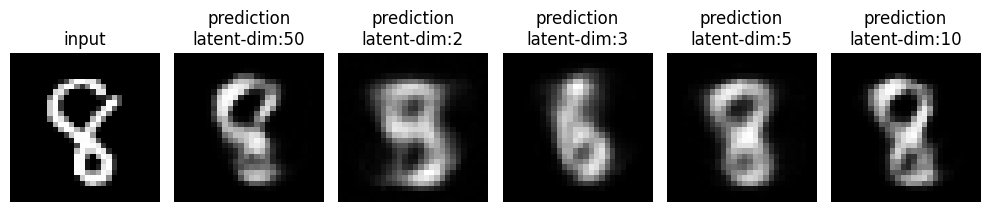

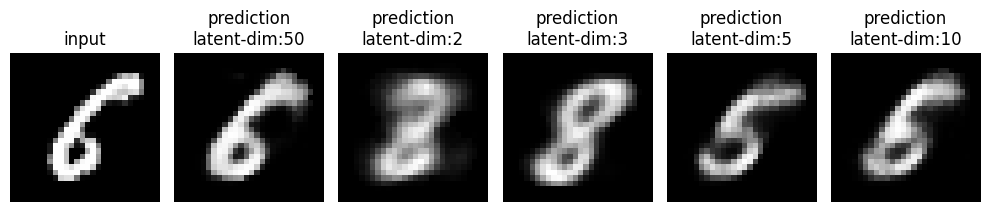

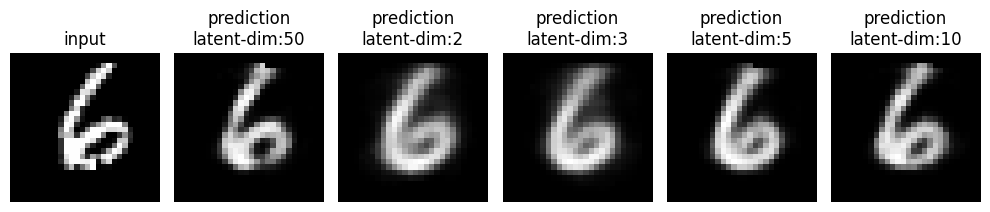

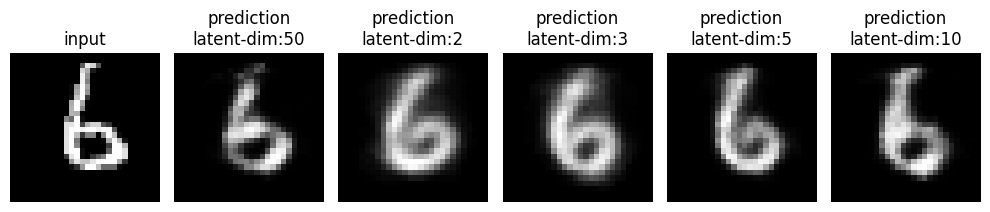

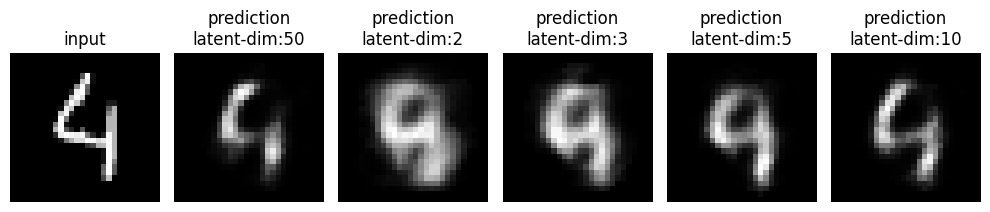

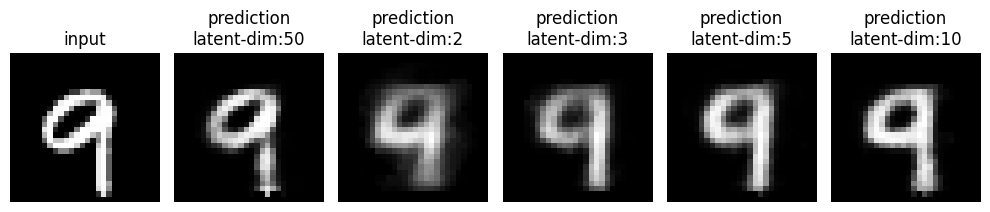

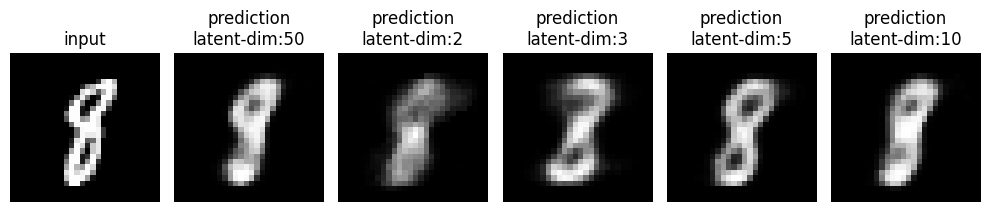

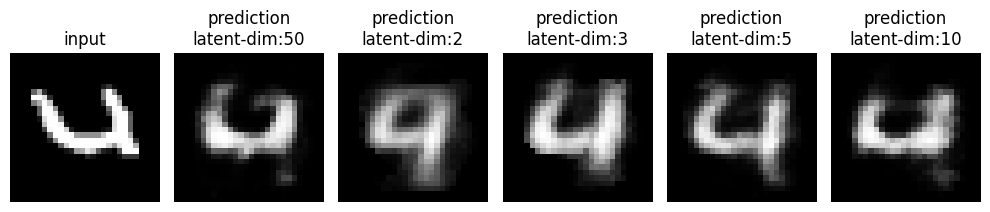

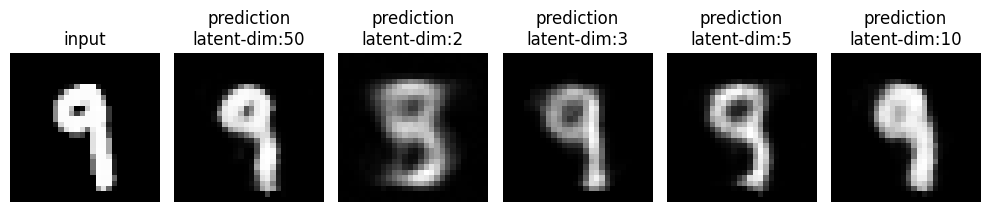

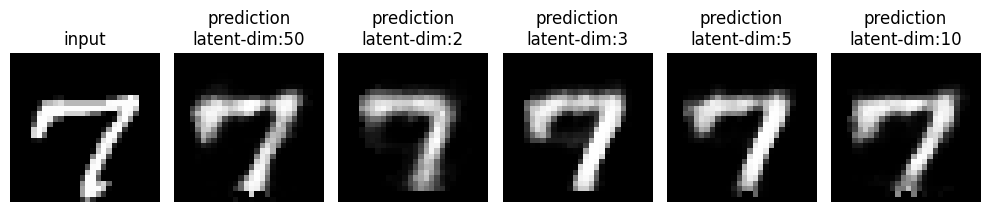

In [ ]:

for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    simple_show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        simple_show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()